In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA

import scipy as sp
from theano.compile.ops import as_op
from numpy import arange, array, empty
from Plot_raw import *

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


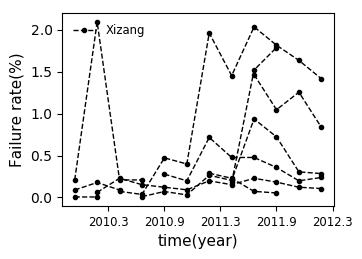

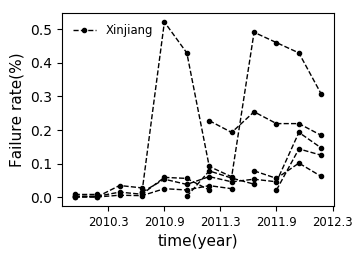

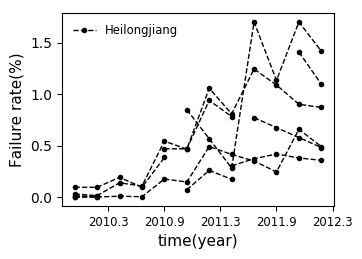

0

In [2]:
Savefig =0
plt.style.use('default')
data_plot = pd.read_csv('XZnozero_12_stop.csv')
year_plot = data_plot.Year.values  # 观测时间值x1
year_plot = np.ma.masked_values(year_plot, value=-999)
# print(year_plot)

faults_plot = (data_plot.Fault.values)  # 数组形式,计算故障率大小
faults_plot = np.ma.masked_values(faults_plot, value=-999)
faults_plot = 100*faults_plot / data_plot.Nums.values

# 将故障率以6组一行形式组成数组,变成：21*6
year_plot2 = np.array([year_plot[i*12:(i+1)*12] for i in np.arange(21)])
faults_plot2 = np.array([faults_plot[i*12:(i+1)*12] for i in np.arange(21)])

year_plot2 = np.ma.masked_values(year_plot2, value=-999)
faults_plot2 = np.ma.masked_values(faults_plot2, value=100)

Plot_raw(year_plot2, faults_plot2, Savefig)

In [3]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储
plt.style.use('default')
elec_data = pd.read_csv('XZnozero_12_stop_stor.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 1, size=[len(elec_data.Year.values), 3])

# #特征因素分析
elec_tem = elec_data.Tem.values # 观测温度值x2，温度不加噪声
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 0]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 1] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 2] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)

# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
# data_cs_year = 
print(elec_year[116:])

# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 1000*(elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
elec_faults[3] = 2
elec_faults[79] = 2
print(elec_faults)
 
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*12:(i+1)*12] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*12:(i+1)*12] for i in np.arange(21)])
# elec_faults2 = np.ma.masked_values(elec_faults2, value=1000)

# Plot_raw(elec_year2, elec_faults2, Savefig)
# 共享变量设置

ys_faultsA = shared(np.asarray(elec_faults[:58]))
ys_faultsB = shared(np.asarray(elec_faults[58:116]))
ys_faultsC = shared(np.asarray(elec_faults[116:]))

xs_yearA = shared(np.asarray(elec_year[:58]))
xs_yearB = shared(np.asarray(elec_year[58:116]))
xs_yearC = shared(np.asarray(elec_year[116:]))
# Num_shared = shared(np.asarray(companyABC))

def logit(x):
    return 1/(1+np.exp(-x))
def Invlogit(x):
    return tt.exp(x)/(1+tt.exp(x))

[ 1  1  1  1  1  2  2  2  2  2  3  3  3  4  4  4  5  5  5  5  6  6  6  6
  6  7  7  7  7  7  8  8  8  8  8  8  9  9  9  9  9 10 10 10 10 10 11 11
 11 11 11 11 12 12 12 12 12 12]
[ 2.  0.  1.  2.  0.  1.  2.  2.  2.  1.  1.  0.  2.  2.  0.  1.  1.  3.
  5.  0.  1.  2.  4.  3.  3.  2.  7. 20.  2.  2.  2.  5.  2. 15.  9. 15.
  1.  2.  5. 15. 20.  7. 10.  1.  2.  4. 18. 18.  3. 13.  1.  2. 16.  3.
  8.  1.  2. 14.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  1.  2.  0.  1.  0.  4.  0.  0.  0.  2.  1.  1.
  1.  0.  2.  0.  1.  1.  1.  3.  1.  5.  0.  1.  0.  2.  0.  5.  1.  1.
  2.  2.  4.  1.  1.  2.  1.  3.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  1.  2.  0.  1.  1.  2.  5.  4.  5.  1.  1.  5.  8.  5.  3.  5. 11.
  6.  9.  2.  4.  3.  8.  3.  8.  4.  4. 12.  8. 17.  2.  4. 11.  7. 11.
  7.  4.  6. 17. 14.  9.  5.  4.  9.  5. 14. 11.]


In [4]:
# 噪声处理
import agate
import agatestats
table = agate.Table.from_csv('outline_fault_C.csv')

outliers = table.stdev_outliers('Fault', deviations=2, reject=True)
# print(outliers)
# print(len(outliers.rows))
outliers1 = table.mad_outliers('Fault', deviations=3, reject=False)
# print(outliers1)
# print(len(outliers1.rows))
# outliers.to_csv('outline.csv')

In [5]:
# 采用三次B样条基函数进行拟合
x_zhou = 12 #为实现短期预测，这里必须要取12以上的值否则无法进行长期的预测，
Num = len(elec_faults[:58])
knots = np.linspace(0, x_zhou, Num)

Num_5 = 5 * len(elec_faults[:58])#长度为290
# Num_5 = shared(Num_51)
model_knots = np.linspace(1, x_zhou, Num_5)


# 能否将这里代码改为@as_op的形式，来让x的值得以调用
basis_funcs = sp.interpolate.BSpline(knots, np.eye(Num_5), k=3) # eye()生成对角矩阵
Bx = basis_funcs(xs_yearA.get_value())  # 表示在取值为x时的插值函数值
BxB = basis_funcs(xs_yearB.get_value())  # 表示在取值为x时的插值函数值
BxC = basis_funcs(xs_yearC.get_value())  # 表示在取值为x时的插值函数值
# shared:符号变量（symbolic variable），a之所以叫shared variable是因为a的赋值在不同的函数中都是一致的搜索，即a是被shared的
Bx_ = shared(Bx)
Bx_B = shared(BxB)
Bx_C = shared(BxC)


In [34]:
Bx_.set_value(basis_funcs(xs_yearA.get_value()))
# 建模，模型
with pm.Model() as model_1:
    # define priors
    alpha = pm.HalfCauchy('alpha', 10., testval=1.15)
    
    σ_a = pm.HalfCauchy('σ_a', 5.)
    a0 = pm.Normal('a0', 0., 10.)
    Δ_a = pm.Normal('Δ_a', 0., 20., shape = (Num_5))
    
    sigmaA = pm.Uniform('sigmaA', lower=0,upper=3 )
    
    σ_aB = pm.HalfCauchy('σ_aB', 5.)
    a0B = pm.Normal('a0B', 0., 10., testval=-3)
    Δ_aB = pm.Normal('Δ_aB', 0., 20., shape = (Num_5))
    
    sigmaB = pm.Uniform('sigmaB', lower=0,upper=3 )
    
    σ_aC = pm.HalfCauchy('σ_aC', 5.)
    a0C = pm.Normal('a0C', 0., 10.)
    Δ_aC = pm.Normal('Δ_aC', 0., 20., shape = (Num_5))
    
    sigmaC = pm.Uniform('sigmaC', lower=0,upper=3 )
    
    theta1 = pm.Deterministic('theta1', a0 + (σ_a * Δ_a).cumsum())
#     theta = pm.Deterministic('theta',   tt.exp(Bx_.dot(theta1)   + δ  + beta*elec_tem1[0:84]+ beta1*elec_RH1[0:84]))
#     theta = pm.Deterministic('theta',  tt.exp(Bx_.dot(theta1)+δ))
    theta = pm.Deterministic('theta',  tt.exp( Bx_.dot(theta1) +  sigmaA*(tt.sqrt(σ_a*σ_a + a0*a0))))
    
    theta1B = pm.Deterministic('theta1B', a0B + (σ_aB * Δ_aB).cumsum())
    thetaB = pm.Deterministic('thetaB', tt.exp(Bx_B.dot(theta1B) +  sigmaB*(tt.sqrt(σ_aB*σ_aB + a0B*a0B))))
    
    theta1C = pm.Deterministic('theta1C', a0C + (σ_aC * Δ_aC).cumsum())
    thetaC = pm.Deterministic('thetaC', tt.exp(Bx_C.dot(theta1C) +  sigmaC*(tt.sqrt(σ_aC*σ_aC + a0C*a0C))))
    
    Observed = pm.Weibull('Observed',alpha=alpha, beta =theta, observed=ys_faultsA)  # 观测值
    ObservedB = pm.Weibull('ObservedB',alpha=alpha, beta =thetaB, observed=ys_faultsB)  # 观测值
    ObservedC = pm.Weibull('ObservedC',alpha=alpha, beta =thetaC, observed=ys_faultsC)  # 观测值  


#     step1 = pm.Slice([Δ_a])
    start = pm.find_MAP()
    trace_1 = pm.sample(1000,start=start,  njobs=1)

logp = -3,695.2, ||grad|| = 0.087693: 100%|█████████████████████████████████████████| 418/418 [00:00<00:00, 672.09it/s]
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: Deprecation

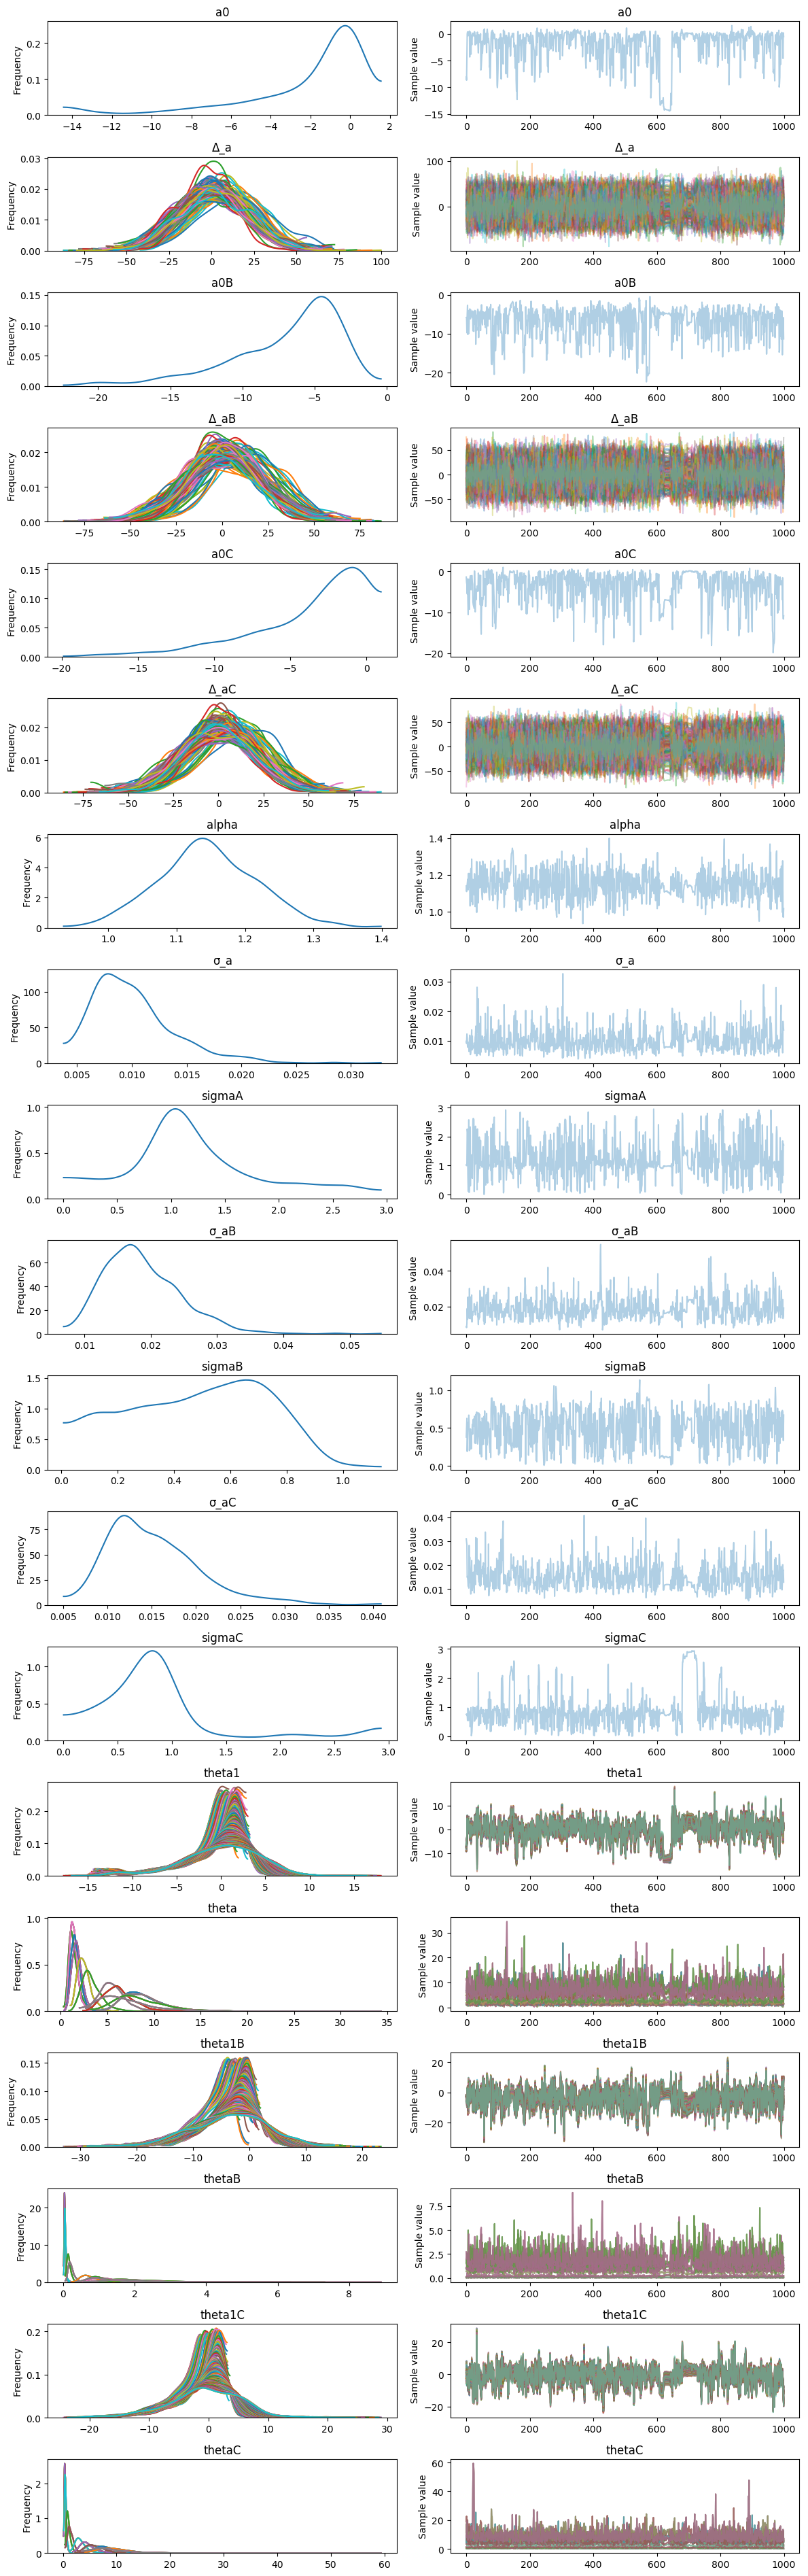

In [35]:
pm.traceplot(trace_1)
plt.show()

In [36]:
pm.waic(trace_1, model_1)

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:213: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        


WAIC_r(WAIC=596.9472130579989, WAIC_se=44.589522125156144, p_WAIC=20.888649355421112)

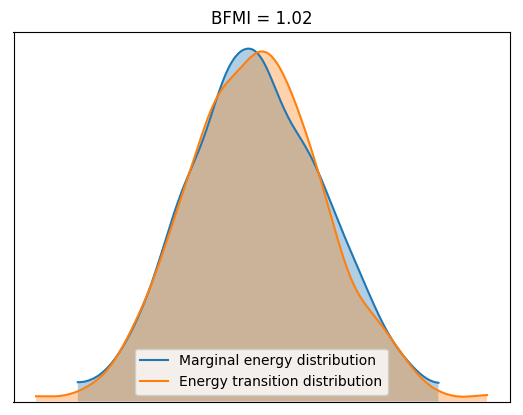

          mean        sd  mc_error    hpd_2.5  hpd_97.5
σ_a   0.010184  0.003812  0.000169   0.004555  0.018326
σ_aB  0.018875  0.005985  0.000283   0.009294  0.030360
σ_aC  0.015232  0.005280  0.000265   0.005945  0.025649
a0   -2.217985  3.331077  0.257635  -9.798050  1.085401
a0B  -6.989539  3.859131  0.201426 -15.369994 -1.682841
a0C  -3.820735  3.897331  0.230683 -11.934218  0.568670


In [38]:
ax = pm.energyplot(trace_1)
bfmi = pm.bfmi(trace_1)
ax.set_title(f"BFMI = {bfmi:.2f}");
plt.show()
varnames2 = ['σ_a', 'σ_aB','σ_aC', 'a0', 'a0B', 'a0C']
tmp0 = pm.df_summary(trace_1, varnames2)
print(tmp0)

In [39]:
Bx_.set_value(basis_funcs(xs_yearA.get_value()))
# 建模，模型,用作算法对比,将一阶回归换成高斯游走
with pm.Model() as model_3:
    # define priors
    alpha3 = pm.HalfCauchy('alpha3', 10., testval=1.15)
    
    beta0 = pm.GaussianRandomWalk('beta0', sd=1, shape=Num_5)
    beta1 = pm.GaussianRandomWalk('beta1', sd=1, shape=Num_5)
    beta2 = pm.GaussianRandomWalk('beta2', sd=1, shape=Num_5)
    
    sigmaA = pm.Uniform('sigmaA', lower=0.01,upper=3 )
    δ = pm.Normal('δ', 0, sd=sigmaA) # 若模型收敛差则δ改用这个语句
    
    sigmaB = pm.Uniform('sigmaB', lower=0.01,upper=3 )
    δB = pm.Normal('δB', 0, sd=sigmaB) # 若模型收敛差则δ改用这个语句
    
    sigmaC = pm.Uniform('sigmaC', lower=0.01,upper=3 )
    δC = pm.Normal('δC', 0, sd=sigmaC) # 若模型收敛差则δ改用这个语句
    
#     theta1 = pm.Deterministic('theta1', a0 + (σ_a * Δ_a).cumsum())
    theta1 = pm.Deterministic('theta1',  (beta0).cumsum())
#     theta = pm.Deterministic('theta',   tt.exp(Bx_.dot(theta1)   + δ  + beta*elec_tem1[0:84]+ beta1*elec_RH1[0:84]))
    theta3 = pm.Deterministic('theta3',  tt.exp(Bx_.dot(theta1)+δ))
    
    theta1B = pm.Deterministic('theta1B', (beta1).cumsum())
    theta3B = pm.Deterministic('theta3B', tt.exp(Bx_B.dot(theta1B) + δB))
    
    theta1C = pm.Deterministic('theta1C',(beta2).cumsum())
    theta3C = pm.Deterministic('theta3C', tt.exp(Bx_C.dot(theta1C) + δC))
    
#     Observed = pm.Poisson('Observed', mu =theta, observed=ys_faultsA)  # 观测值
#     ObservedB = pm.Poisson('ObservedB', mu =thetaB, observed=ys_faultsB)  # 观测值
#     ObservedC = pm.Poisson('ObservedC', mu =thetaC, observed=ys_faultsC)  # 观测值
    
    Observed3 = pm.Weibull('Observed3',alpha=alpha3, beta =theta3, observed=ys_faultsA)  # 观测值
    Observed3B = pm.Weibull('Observed3B',alpha=alpha3, beta =theta3B, observed=ys_faultsB)  # 观测值
    Observed3C = pm.Weibull('Observed3C',alpha=alpha3, beta =theta3C, observed=ys_faultsC)  # 观测值  
#     step1 = pm.Slice([Δ_a])
    start = pm.find_MAP()
    trace_3 = pm.sample(1000,start=start,  njobs=1)

logp = -1,059.8, ||grad|| = 0.2259: 100%|███████████████████████████████████████████| 848/848 [00:01<00:00, 715.81it/s]
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: Deprecation

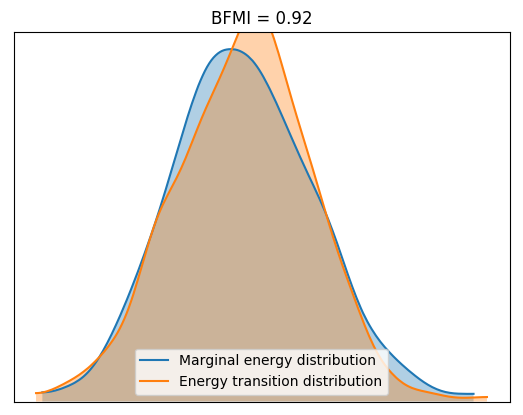

In [40]:
ax = pm.energyplot(trace_3)
bfmi3 = pm.bfmi(trace_3)
ax.set_title(f"BFMI = {bfmi3:.2f}");
plt.show()


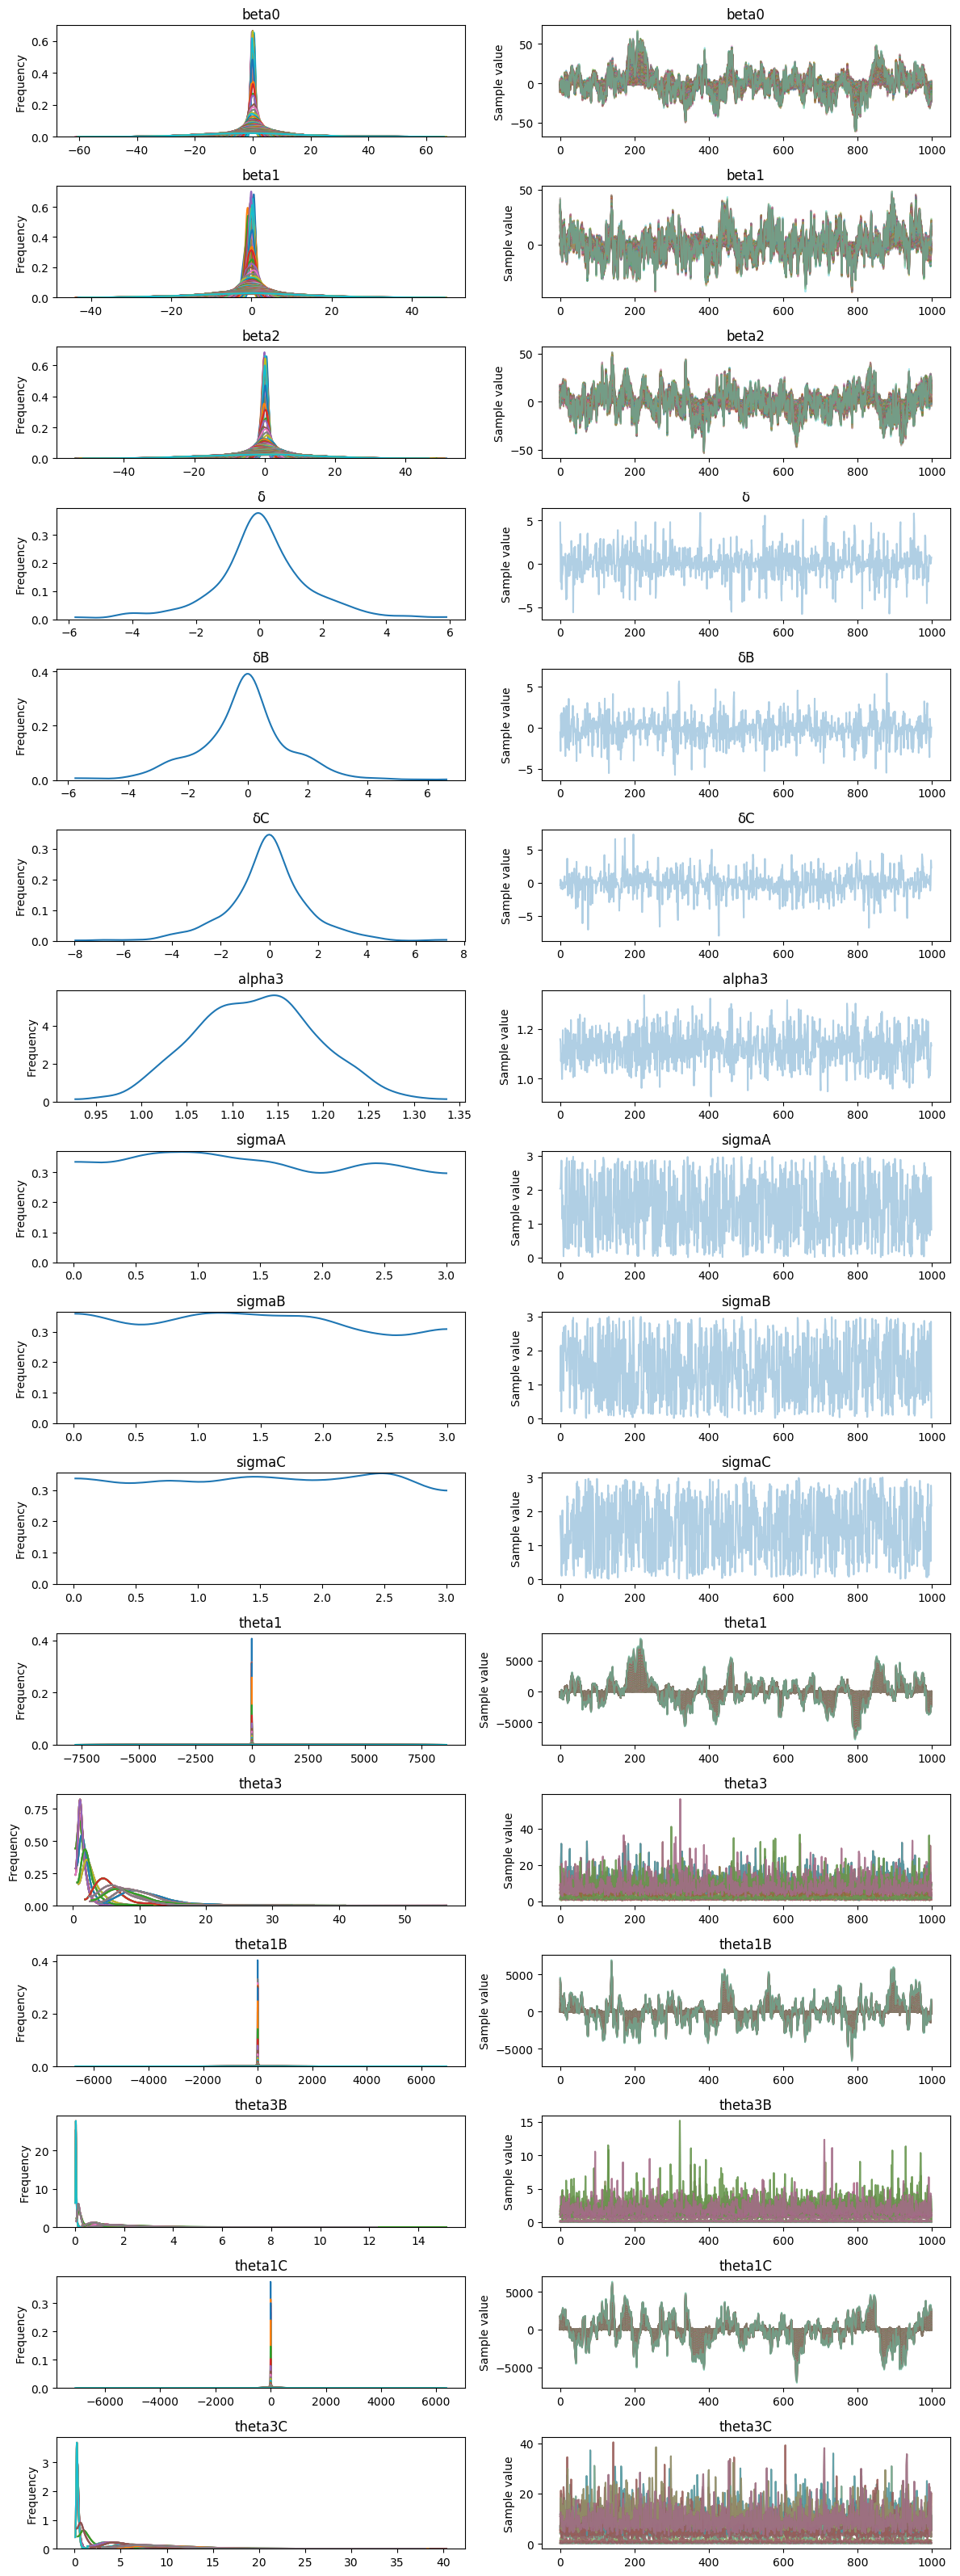

In [41]:
pm.traceplot(trace_3)
plt.show()

In [42]:
traces = [trace_1, trace_3]
pm.densityplot(traces);

AttributeError: module 'pymc3' has no attribute 'densityplot'

In [43]:
WAIC3 = pm.compare([trace_1, trace_3], [model_1, model_3], ic='WAIC')
print('WAIC1: ',WAIC3)

# Leave-one-out Cross-validation
df_comp_LOO = pm.compare([trace_1, trace_3], [model_1, model_3], ic='LOO')
print(df_comp_LOO)

WAIC1:       WAIC  pWAIC  dWAIC weight     SE  dSE warning
0  596.95  20.89      0      1  44.59    0       1
1  613.89  30.31  16.94      0  45.24  6.8       1
      LOO   pLOO   dLOO weight     SE   dSE warning
0  604.49  24.66      0      1  45.21     0       1
1   625.9  36.32  21.41      0  45.94  8.07       1


In [44]:
# 后验分析
varnames2 = ['theta3', 'theta3B','theta3C']
tmp3 = pm.df_summary(trace_3, varnames2)

MAP_tmp3 = tmp3['mean']
# 计算均方误差
def Rmse(predictions, targets):
    return  np.sqrt(np.mean((predictions - targets)**2))

ALL_faults3 = (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
MAP_tmp3 = MAP_tmp3/1000
rmse3 = {}
for ip in np.arange(3):
    rmse3[ip] = Rmse(MAP_tmp3[ip*58:(ip+1)*58], ALL_faults3[ip*58:(ip+1)*58])
print('用于对比模型高斯游走3:', rmse3)


用于对比模型高斯游走3: {0: 0.0055685010177768494, 1: 0.0011598927663081827, 2: 0.003296402212605209}


[ 1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5  6  6  6  6  7
  7  7  7  7  8  8  8  8  8  8  9  9  9  9  9  9  9 10 10 10 10 10 10 10
 11 11 11 11 13 12 12 12 12 14]


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  0%|                              

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  9%|███████                                                                         | 89/1000 [00:01<00:13, 66.65it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

 11%|████████▌                                                                      | 108/1000 [00:01<00:11, 75.02it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

 20%|███████████████▎                                                              | 196/1000 [00:01<00:07, 100.53it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 30%|███████████████████████▊                                                      | 305/1000 [00:02<00:05, 118.31it/s]D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 50%|███████████████████████████████████████                                       | 501/1000 [00:03<00:03, 134.36it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 61%|███████████████████████████████████████████████▌                              | 609/1000 [00:04<00:02, 139.95it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 70%|██████████████████████████████████████████████████████▎                       | 697/1000 [00:04<00:02, 142.65it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 80%|██████████████████████████████████████████████████████████████▊               | 805/1000 [00:05<00:01, 145.70it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

[1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 2.e+00 2.e+00 2.e+00
 2.e+00 2.e+00 2.e+00 2.e+00 2.e+00 2.e+00 2.e+00 2.e+00 2.e+00 3.e+00
 3.e+00 3.e+00 3.e+00 5.e+00 5.e+00 5.e+00 5.e+00 5.e+00 6.e+00 6.e+00
 6.e+00 6.e+00 6.e+00 6.e+00 9.e+00 9.e+00 8.e+00 9.e+00 8.e+00 9.e+00
 8.e+00 8.e+00 9.e+00 9.e+00 9.e+00 8.e+00 8.e+00 9.e+00 9.e+00 8.e+00
 8.e+00 8.e+00 1.e+12 7.e+00 7.e+00 7.e+00 7.e+00 2.e+63]


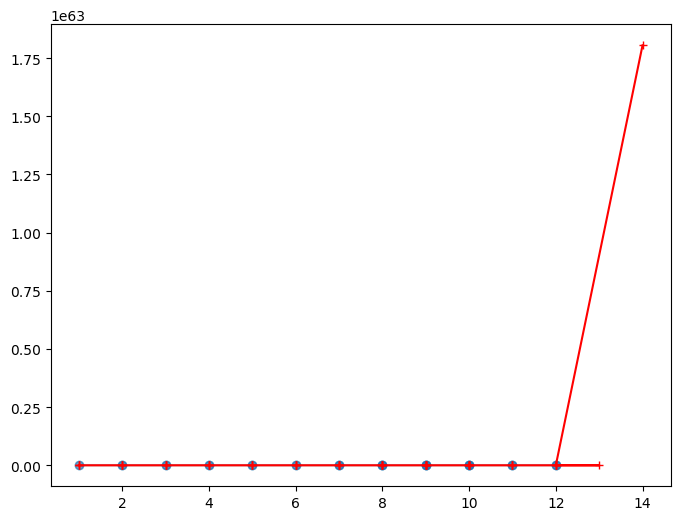

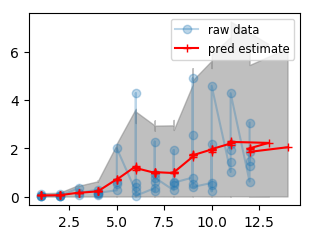

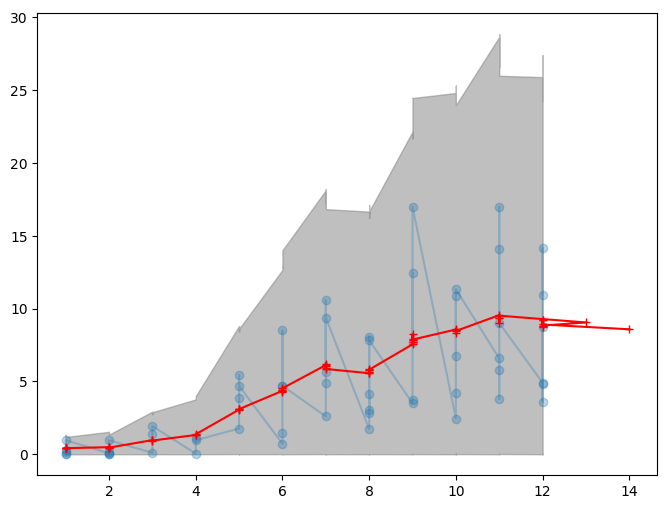

In [45]:
# 后验。第7年数据,貌似没法进行第7年的预测
data_cs = pd.read_csv('XZnozero_12_stop_stor_pred.csv')
data_cs_year = data_cs.Year.values # 测试数据时间
# data_cs_year[54:56] = 13
# data_cs_year[56:58] = 14
Bx_.set_value(basis_funcs(data_cs_year[:58]))
# # Bx_B.set_value(basis_funcs(data_cs_year[58:116]))
# # Bx_C.set_value(basis_funcs(data_cs_year[116:]))

# data_cs_year = elec_year
print(data_cs_year[:58])
Savefig=0
with model_1:
    ppcc = pm.sample_ppc(trace_1)
post_pred = ppcc['Observed']
yipred_mean = post_pred.mean(axis=0)
post_predB = ppcc['ObservedB']
yipred_meanB = post_predB.mean(axis=0)
post_predC = ppcc['ObservedC']
yipred_meanC = post_predC.mean(axis=0)
print(yipred_mean)
sig0 = pm.hpd(post_pred, alpha=0.05)
sig1 = pm.hpd(post_predB, alpha=0.05)
sig2 = pm.hpd(post_predC, alpha=0.05)
# print(sig0)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)
ip = 0
ax.plot(elec_year[:58], elec_faults[:58], marker='o', alpha=.3)

plt.fill_between(elec_year[:58], sig0[:,0], sig0[:,1], color='gray', alpha=.5) 

ax.plot(data_cs_year[:58], yipred_mean, 'k+-', color='r')  
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred0.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(3.5, 2.5))
ax = plt.subplot(1, 1, 1)
ip = 1
ax.plot(elec_year[58:116], elec_faults[58:116], marker='o', alpha=.3, label="raw data")

plt.fill_between(data_cs_year[58:116], sig1[:,0], sig1[:,1], color='gray', alpha=.5) 

ax.plot(data_cs_year[58:116], yipred_meanB, 'k+-', color='r', label="pred estimate")
ax.legend(fontsize='small')
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\EI\\Picture\\Pred1.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)
ip = 2
ax.plot(elec_year[116:], elec_faults[116:], marker='o', alpha=.3)

plt.fill_between(elec_year[116:], sig2[:,0], sig2[:,1], color='gray', alpha=.5) 

ax.plot(data_cs_year[116:], yipred_meanC, 'k+-', color='r')  
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred0.png', dpi = 200, bbox_inches='tight')
plt.show()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 21%|████████████████▏                                                             | 207/1000 [00:01<00:04, 181.49it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

 23%|█████████████████▋                                                            | 226/1000 [00:01<00:04, 181.91it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 45%|███████████████████████████████████▎                                          | 453/1000 [00:02<00:03, 180.96it/s]D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 58%|█████████████████████████████████████████████▏                                | 580/1000 [00:03<00:02, 178.42it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

 71%|███████████████████████████████████████████████████████▏                      | 707/1000 [00:03<00:01, 177.45it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 82%|███████████████████████████████████████████████████████████████▋              | 816/1000 [00:04<00:01, 177.22it/s]D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 92%|████████████████████████████████████████████████████████████████████████      | 924/1000 [00:05<00:00, 176.52it/s]D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

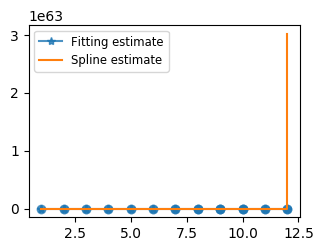

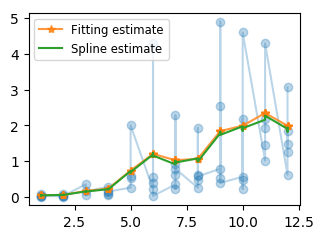

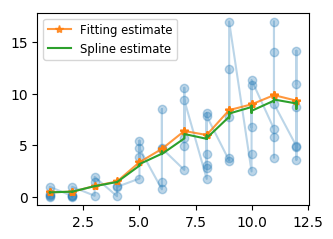

In [46]:
# 后验分析
varnames2 = ['theta', 'thetaB','thetaC']
tmp0 = pm.df_summary(trace_1, varnames2)

MAP_tmp0 = tmp0['mean']
betaMAP = tmp0['mean'][:58]
betaMAPB = tmp0['mean'][58:116]
betaMAPC = tmp0['mean'][116:]
# print(betaMAPB)

with model_1:
    pp_trace = pm.sample_ppc(trace_1, 1000)
post_pred = pp_trace['Observed']
yipred_mean = post_pred.mean(axis=0)
post_predB = pp_trace['ObservedB']
yipred_meanB = post_predB.mean(axis=0)
post_predC = pp_trace['ObservedC']
yipred_meanC = post_predC.mean(axis=0)

ip=0
fig, ax = plt.subplots(figsize=(3.5, 2.5))
x_plot = np.linspace(0.9, 12.1, 12)
low, high = np.percentile(pp_trace['Observed'], [5, 95], axis=0)
 
# xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
# yp = elec_faults2[ip*7:(ip+1)*7, :]
ax.scatter(elec_year[:58], elec_faults[:58], marker='o', alpha=.3)
ax.plot(elec_year[:58], betaMAP[:58], marker='*', alpha=.8, label="Fitting estimate")
# ax.fill_between(elec_year[:58], low[:58], high[:58],  alpha=0.5)
ax.plot(elec_year[:58], pp_trace['Observed'].mean(axis=0)[:58], label="Spline estimate")
# ax.set_xlim(0, 1)
ax.legend(fontsize='small')
Savefig=0
if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\EI\\Picture\\Fitting1.png', dpi = 200, bbox_inches='tight')

plt.show()


ip=1
fig, ax = plt.subplots(figsize=(3.5, 2.5))
x_plot = np.linspace(0.9, 12.1, 12)
low, high = np.percentile(pp_trace['ObservedB'], [5, 95], axis=0)

# xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
# yp = elec_faults2[ip*7:(ip+1)*7, :]
# ax.plot(xp, yp, marker='o', alpha=.8)
ax.plot(elec_year[58:116], elec_faults[58:116], marker='o', alpha=.3)
ax.plot(elec_year[58:116], betaMAPB[:], marker='*', alpha=.8, label="Fitting estimate")
# ax.fill_between(elec_year[58:116], low, high,  alpha=0.5)
ax.plot(elec_year[58:116], pp_trace['ObservedB'].mean(axis=0), label="Spline estimate")
# ax.set_xlim(0, 1)
ax.legend(fontsize='small')
Savefig=0
if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\EI\\Picture\\Fitting2.png', dpi = 200, bbox_inches='tight')

plt.show()


ip=2
fig, ax = plt.subplots(figsize=(3.5, 2.5))
x_plot = np.linspace(0.9, 12.1, 12)
low, high = np.percentile(pp_trace['ObservedC'], [5, 95], axis=0)

# xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
# yp = elec_faults2[ip*7:(ip+1)*7, :]
# ax.plot(xp, yp, marker='o', alpha=.8)
ax.plot(elec_year[116:], elec_faults[116:], marker='o', alpha=.3)
ax.plot(elec_year[116:], betaMAPC[:], marker='*', alpha=.8, label="Fitting estimate")
# ax.fill_between(elec_year[116:], low, high,  alpha=0.5)
ax.plot(elec_year[116:], pp_trace['ObservedC'].mean(axis=0), label="Spline estimate")
# ax.set_xlim(0, 1)
ax.legend(fontsize='small')

if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\EI\\Picture\\Fitting3.png', dpi = 200, bbox_inches='tight')
plt.show()

In [47]:
# 计算均方误差
def Rmse(predictions, targets):
    return  np.sqrt(np.mean((predictions - targets)**2))


ALL_faults = (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小

MAP_tmp0 = MAP_tmp0/1000
rmse0 = {}
for ip in np.arange(3):
    rmse0[ip] = Rmse(MAP_tmp0[ip*58:(ip+1)*58], ALL_faults[ip*58:(ip+1)*58])

print('本文模型:    ', rmse0)

本文模型:     {0: 0.005537036263774417, 1: 0.0011585745319336752, 2: 0.0032025632848096484}


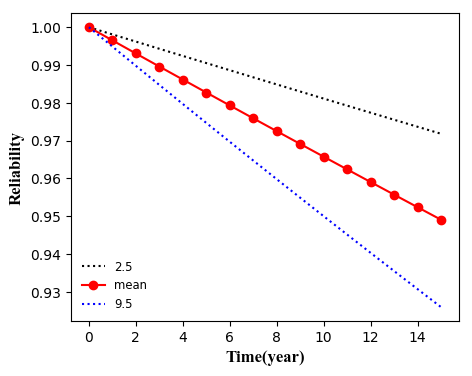

In [48]:
font1 ={'family': 'times new roman', 'weight':'light', 'size': 12}  
chain1 = trace_1
# 可靠度计算，beta_mu要除以100还原
post_alpha1 = np.mean(chain1['alpha'])
post_beta_mu1 = (np.mean(chain1['theta'])/1000+np.mean(chain1['thetaB'])/1000+np.mean(chain1['thetaC'])/1000)/3

varnames1 = ['alpha', 'theta', 'thetaB', 'thetaC']
aaa1 = pm.df_summary(chain1, varnames1)
bbb1 = pd.DataFrame(aaa1)

hpdd2_5 = bbb1['hpd_2.5']
hpdd97_5 = bbb1['hpd_97.5']
hpd2_5_alpha = hpdd2_5[:1].mean()
hpd97_5_alpha = hpdd97_5[:1].mean()
hpd25_beta_mu = hpdd2_5[1:].mean()/1000
hpd975_beta_mu = hpdd97_5[1:].mean()/1000

# 可靠度函数：这里为故障度函数
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
t = np.arange(0, 16, 1)
R1 = np.exp(-((t/post_beta_mu1)**post_alpha1))
R2 = np.exp(-((t/hpd25_beta_mu)**hpd2_5_alpha))
R3 = np.exp(-((t/hpd975_beta_mu)**hpd97_5_alpha))
# plt.plot(t, R2, 'k:', t, R1, 'bo-', t, R3, 'r:')
# 需要进行转换以进行可靠度分析，依据书71页的表达式，可反推出可靠度函数
R11 = np.exp(-((t/post_alpha1)*post_beta_mu1))
R22 = np.exp(-((t/hpd2_5_alpha)*hpd25_beta_mu))
R33 = np.exp(-((t/hpd97_5_alpha)*hpd975_beta_mu))

plt.plot(t, R22, 'k:', t, R11, 'ro-', t, R33, 'b:')
# ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'], fontsize='small')
ax.set_xlabel("Time(year)", fontdict=font1)
plt.ylabel("Reliability", fontdict=font1)
# plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
ax.legend(['2.5','mean','9.5'], loc='lower left',frameon=False, fontsize='small')

# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\EI\\Picture\\Reliability111.png', dpi = 300, bbox_inches='tight')
plt.show()


In [49]:
# elec_faults[3] = 2
# 建模，模型
with pm.Model() as model_2:
    # define priors
    alpha = pm.HalfCauchy('alpha', 10.)
    
    δ = pm.Normal('δ', 0, sd=10) # 若模型收敛差则δ改用这个语句
    δB = pm.Normal('δB', 0, sd=10) # 若模型收敛差则δ改用这个语句
    δC = pm.Normal('δC', 0, sd=10) # 若模型收敛差则δ改用这个语句
    
    beta = pm.Normal('beta', 0, sd=100)
    beta1 = pm.Normal('beta1', 0, sd=100)
    beta2 = pm.Normal('beta2', 0, sd=100)

    Abeta = pm.Normal('Abeta', 0, sd=100)
    Bbeta1 = pm.Normal('Bbeta1', 0, sd=100)
    Cbeta2 = pm.Normal('Cbeta2', 0, sd=100)
    
    theta = pm.Deterministic('theta2',  tt.exp( beta*elec_year[:58] + Abeta*(elec_year[:58]**2) +δ))
    thetaB = pm.Deterministic('theta2B', tt.exp( beta1*elec_year[58:116] + Bbeta1*(elec_year[58:116]**2)+ δB))
    thetaC = pm.Deterministic('theta2C', tt.exp( beta2*elec_year[116:] + Cbeta2*(elec_year[116:]**2)+ δC))
    
    Observed = pm.Weibull('Observed2',alpha=alpha, beta =theta, observed=elec_faults[0:58])  # 观测值
    ObservedB = pm.Weibull('Observed2B',alpha=alpha, beta =thetaB, observed=elec_faults[58:116])  # 观测值
    ObservedC = pm.Weibull('Observed2C',alpha=alpha, beta =thetaC, observed=elec_faults[116:])  # 观测值
#     step1 = pm.Slice([Δ_a])
    start = pm.find_MAP()
    trace_2 = pm.sample(1000,start=start,  njobs=1)

logp = -328.98, ||grad|| = 1.7027: 100%|███████████████████████████████████████████| 356/356 [00:00<00:00, 1224.94it/s]
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\sampling.py:310: Deprecation

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 20%|███████████████▎                                                              | 197/1000 [00:01<00:05, 160.48it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

 22%|████████████████▊                                                             | 216/1000 [00:01<00:04, 162.11it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 53%|█████████████████████████████████████████▍                                    | 532/1000 [00:02<00:02, 181.98it/s]D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 71%|███████████████████████████████████████████████████████▎                      | 709/1000 [00:03<00:01, 180.97it/s]D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 73%|████████████████████████████████████████████████████████▊                     | 728/1000 [00:04<00:01, 180.76it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

 75%|██████████████████████████████████████████████████████████▎                   | 747/1000 [00:04<00:01, 180.93it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\distributions\distribution.py:318: DeprecationWarning: The truth value of an empty array is am

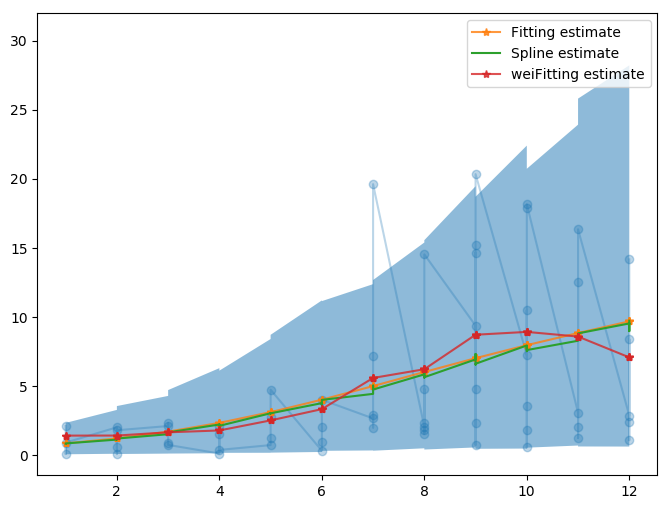

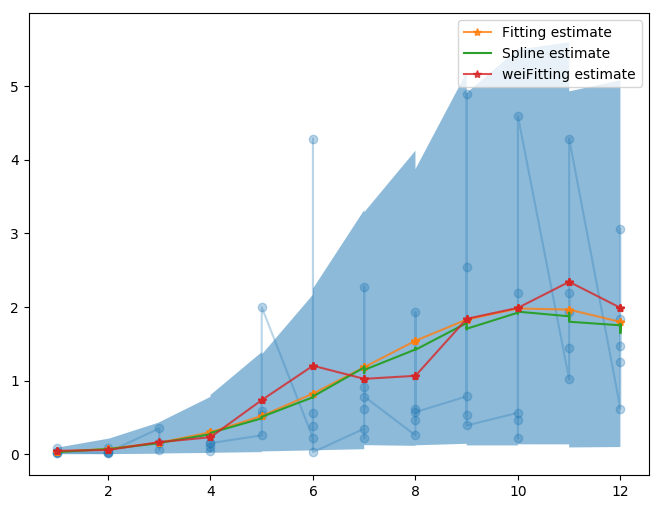

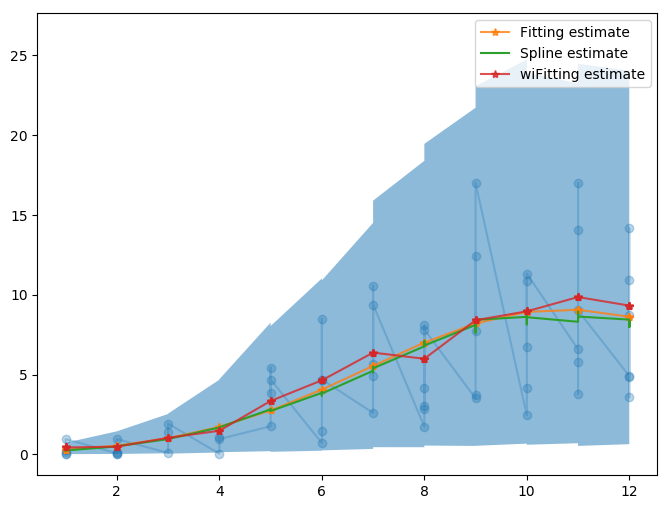

In [50]:
# 后验分析
varnames2 = ['theta2', 'theta2B','theta2C']
tmp = pm.df_summary(trace_2, varnames2)

MAP_tmp = tmp['mean']
betaMAP2 = tmp['mean'][:58]
betaMAPB2 = tmp['mean'][58:116]
betaMAPC2 = tmp['mean'][116:]
# print(betaMAPB)

# 这12行用于计算误差
# XZ_mean = np.arange(12)+0.1
# XZ_mean[0] = MAP_tmp[0];XZ_mean[1] = MAP_tmp[3];XZ_mean[2] = MAP_tmp[8];XZ_mean[3] = MAP_tmp[14]
# XZ_mean[4] = MAP_tmp[18];XZ_mean[5] = MAP_tmp[22];XZ_mean[6] = MAP_tmp[27];XZ_mean[7] = MAP_tmp[32]
# XZ_mean[8] = MAP_tmp[38];XZ_mean[9] = MAP_tmp[46];XZ_mean[10] = MAP_tmp[51];XZ_mean[11] = MAP_tmp[57]

# XZ_meanB = np.arange(12)+0.1
# XZ_meanB[0] = MAP_tmp[62];XZ_meanB[1] = MAP_tmp[67];XZ_meanB[2] = MAP_tmp[70];XZ_meanB[3] = MAP_tmp[75]
# XZ_meanB[4] = MAP_tmp[79];XZ_meanB[5] = MAP_tmp[84];XZ_meanB[6] = MAP_tmp[90];XZ_meanB[7] = MAP_tmp[95]
# XZ_meanB[8] = MAP_tmp[100];XZ_meanB[9] = MAP_tmp[105];XZ_meanB[10] = MAP_tmp[110];XZ_meanB[11] = MAP_tmp[115]

# XZ_meanC = np.arange(12)+0.1
# XZ_meanC[0] = MAP_tmp[120];XZ_meanC[1] = MAP_tmp[125];XZ_meanC[2] = MAP_tmp[128];XZ_meanC[3] = MAP_tmp[131]
# XZ_meanC[4] = MAP_tmp[135];XZ_meanC[5] = MAP_tmp[140];XZ_meanC[6] = MAP_tmp[145];XZ_meanC[7] = MAP_tmp[150]
# XZ_meanC[8] = MAP_tmp[156];XZ_meanC[9] = MAP_tmp[160];XZ_meanC[10] = MAP_tmp[166];XZ_meanC[11] = MAP_tmp[172]


with model_2:
    pp_trace2 = pm.sample_ppc(trace_2, 1000)
ip=0
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0.9, 12.1, 12)
low, high = np.percentile(pp_trace2['Observed2'], [5, 95], axis=0)
 
# xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
# yp = elec_faults2[ip*7:(ip+1)*7, :]
ax.plot(elec_year[:58], elec_faults[:58], marker='o', alpha=.3)
ax.plot(elec_year[:58], betaMAP2[:58], marker='*', alpha=.8, label="Fitting estimate")
ax.fill_between(elec_year[:58], low[:58], high[:58],  alpha=0.5)
ax.plot(elec_year[:58], pp_trace2['Observed2'].mean(axis=0)[:58], label="Spline estimate")

ax.plot(elec_year[:58], betaMAP[:58], marker='*', alpha=.8, label="weiFitting estimate")
# ax.plot(x_plot, XZ_mean, label="true estimate")
# ax.plot(elec_year[:58], betaMAP[:58], marker='*', alpha=.8, label="Fitting estimate")
# ax.set_xlim(0, 1)
ax.legend()
plt.show()


ip=1
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0.9, 12.1, 12)
low, high = np.percentile(pp_trace2['Observed2B'], [5, 95], axis=0)

# xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
# yp = elec_faults2[ip*7:(ip+1)*7, :]
# ax.plot(xp, yp, marker='o', alpha=.8)
ax.plot(elec_year[58:116], elec_faults[58:116], marker='o', alpha=.3)
ax.plot(elec_year[58:116], betaMAPB2[:], marker='*', alpha=.8, label="Fitting estimate")
ax.fill_between(elec_year[58:116], low, high,  alpha=0.5)
ax.plot(elec_year[58:116], pp_trace2['Observed2B'].mean(axis=0), label="Spline estimate")

ax.plot(elec_year[58:116], betaMAPB[:], marker='*', alpha=.8, label="weiFitting estimate")
# ax.plot(x_plot, XZ_meanB, label="true estimate")
# ax.plot(elec_year[58:116], betaMAPB[:], marker='*', alpha=.8, label="Fitting estimate")
# ax.set_xlim(0, 1)
ax.legend()
plt.show()


ip=2
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0.9, 12.1, 12)
low, high = np.percentile(pp_trace2['Observed2C'], [5, 95], axis=0)

# xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
# yp = elec_faults2[ip*7:(ip+1)*7, :]
# ax.plot(xp, yp, marker='o', alpha=.8)
ax.plot(elec_year[116:], elec_faults[116:], marker='o', alpha=.3)
ax.plot(elec_year[116:], betaMAPC2[:], marker='*', alpha=.8, label="Fitting estimate")
ax.fill_between(elec_year[116:], low, high,  alpha=0.5)
ax.plot(elec_year[116:], pp_trace2['Observed2C'].mean(axis=0), label="Spline estimate")

ax.plot(elec_year[116:], betaMAPC[:], marker='*', alpha=.8, label="wiFitting estimate")
# ax.plot(x_plot, XZ_meanC, label="true estimate")
# ax.plot(elec_year[116:], betaMAPC[:], marker='*', alpha=.8, label="Fitting estimate")
# ax.set_xlim(0, 1)
ax.legend()
plt.show()

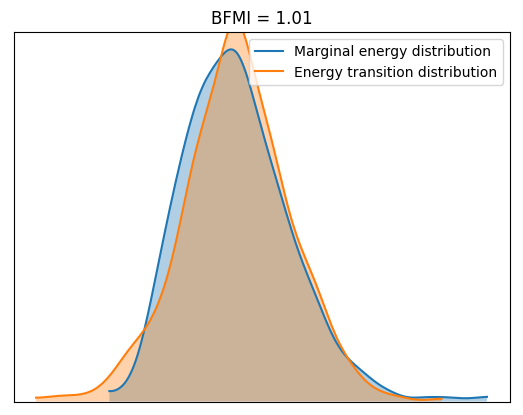

In [51]:
ax = pm.energyplot(trace_2)
bfmi = pm.bfmi(trace_2)
ax.set_title(f"BFMI = {bfmi:.2f}");
plt.show()

In [52]:
WAIC1 = pm.compare([trace_1, trace_2], [model_1, model_2])
print('WAIC1: ',WAIC1)
WAIC = pm.waic(trace=trace_1, model=model_1)
DIC = pm.dic(trace=trace_1, model=model_1)
print(WAIC)
print('DIC: ',DIC)

WAIC1:             WAIC         pWAIC         dWAIC weight     SE  dSE warning
1        588.64         10.31             0   0.95  44.97    0       1
0  9.04743e+229  4.52371e+229  9.04743e+229   0.05    inf  inf       1


D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:213: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        


WAIC_r(WAIC=9.047425597314787e+229, WAIC_se=inf, p_WAIC=4.523712798657393e+229)
DIC:  8.51186563778006e+113


In [53]:
# 计算均方误差
ALL_faults = (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
MAP_tmp = MAP_tmp/1000
rmse2 = {}
for ip in np.arange(3):
    rmse2[ip] = Rmse(MAP_tmp[ip*58:(ip+1)*58], ALL_faults[ip*58:(ip+1)*58])
print('用于对比模型:', rmse2)


用于对比模型: {0: 0.0057579038843202516, 1: 0.0011933450926812296, 2: 0.0032627797061553546}
